In [44]:
# Import required libraries
import requests
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, date
import cufflinks as cf
cf.set_config_file(offline=True)

In [45]:
security = input("For what security do you want an option chain?\n")
security = security.upper()

For what security do you want an option chain?
banknifty


In [46]:
# API url to extract the data from
url = 'https://www.nseindia.com/api/option-chain-indices?symbol='+ security

In [47]:
headers = {
    'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/97.0.4692.99 Safari/537.36'
    ,'accept-encoding': 'gzip, deflate, br'
    ,'accept-language': 'en-US,en;q=0.9'    
}

In [48]:
# Create a session and send request to get the data from the website
session = requests.Session()
request = session.get(url, headers=headers)
cookies = dict(request.cookies)
response = session.get(url, headers=headers, cookies=cookies).json()
rawdata = pd.DataFrame(response)

In [49]:
# Check the data structure of the raw data
rawdata

,records,filtered
expiryDates,"[03-Feb-2022, 10-Feb-2022, 17-Feb-2022, 24-Feb...",NaN
data,"[{'strikePrice': 27000, 'expiryDate': '31-Mar-...","[{'strikePrice': 30400, 'expiryDate': '03-Feb-..."
timestamp,31-Jan-2022 15:30:00,NaN
underlyingValue,37975.3,NaN
strikePrices,"[27000, 28500, 30000, 30400, 30500, 30600, 307...",NaN
index,"{'key': 'SECTORAL INDICES', 'index': 'NIFTY BA...",NaN
CE,NaN,"{'totOI': 832129, 'totVol': 10554463}"
PE,NaN,"{'totOI': 518591, 'totVol': 10581724}"


In [50]:
# Take the required cell into a dataframe to work on it
df= pd.DataFrame(response["records"]['data']).fillna(0)

In [51]:
# Check the structure of the underlying dataframe
df

,strikePrice,expiryDate,PE,CE
0,27000,31-Mar-2022,"{'strikePrice': 27000, 'expiryDate': '31-Mar-2...","{'strikePrice': 27000, 'expiryDate': '31-Mar-2..."
1,27000,30-Jun-2022,"{'strikePrice': 27000, 'expiryDate': '30-Jun-2...",0
2,27000,29-Dec-2022,"{'strikePrice': 27000, 'expiryDate': '29-Dec-2...",0
3,27000,29-Sep-2022,"{'strikePrice': 27000, 'expiryDate': '29-Sep-2...",0
4,28500,30-Jun-2022,"{'strikePrice': 28500, 'expiryDate': '30-Jun-2...",0
...,...,...,...,...
795,46500,31-Mar-2022,"{'strikePrice': 46500, 'expiryDate': '31-Mar-2...","{'strikePrice': 46500, 'expiryDate': '31-Mar-2..."
796,46500,30-Jun-2022,0,"{'strikePrice': 46500, 'expiryDate': '30-Jun-2..."
797,46500,29-Sep-2022,0,"{'strikePrice': 46500, 'expiryDate': '29-Sep-2..."
798,46500,29-Dec-2022,0,"{'strikePrice': 46500, 'expiryDate': '29-Dec-2..."


In [52]:
# Convert the dataframe from a dict structure into a data frame structure
def option_dataframe(df):
    data = []
    for i in range(len(df)):
        call_oi = call_coi = put_oi = put_coi  = int(0)
        call_IV = put_IV = call_ltp = put_ltp = float(0)
        strike = df.iloc[i,0]
        expiry = df.iloc[i,1]
        if(df.iloc[i,-1] == 0):
            calloi = call_coi = 0
        else:
            call_oi = df.iloc[i,-1]["openInterest"]
            call_coi = df.iloc[i,-1]["changeinOpenInterest"]
            call_ltp = df.iloc[i,-1]['lastPrice']
            call_IV = df.iloc[i,-1]['impliedVolatility']
        
        if(df.iloc[i,-2] == 0):
            putoi = put_coi = 0
        else:
            put_oi = df.iloc[i,-2]["openInterest"]
            put_coi = df.iloc[i,-2]["changeinOpenInterest"]
            put_ltp = df.iloc[i,-2]['lastPrice']
            put_IV = df.iloc[i,-2]['impliedVolatility']
            
        option_data = {"Expiry": expiry,
            "Call OI" : call_oi, "Call C_OI" : call_coi,"Call IV": call_IV ,"Call LTP" : call_ltp, "Strike" : strike,
             "Put LTP" : put_ltp ,"Put IV" : put_IV , "Put C_OI" : put_coi, "Put OI" : put_oi
        }
        data.append(option_data)
    optionchain = pd.DataFrame(data)

    return optionchain , df.iloc[0,-2]["underlyingValue"]

In [53]:
# Create an instance of the function by calling it
optionchain  , underlying_ltp = option_dataframe(df) 

In [54]:
# Check the Last traded price of the underlying security
underlying_ltp

37975.35

In [55]:
# Check the dataframe contating the options data
optionchain

,Expiry,Call OI,Call C_OI,Call IV,Call LTP,Strike,Put LTP,Put IV,Put C_OI,Put OI
0,31-Mar-2022,0,0,0.00,0.0,27000,0.0,0.0,0,18
1,30-Jun-2022,0,0,0.00,0.0,27000,0.0,0.0,0,0
2,29-Dec-2022,0,0,0.00,0.0,27000,0.0,0.0,0,0
3,29-Sep-2022,0,0,0.00,0.0,27000,0.0,0.0,0,0
4,30-Jun-2022,0,0,0.00,0.0,28500,0.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...
795,31-Mar-2022,70,7,26.68,74.6,46500,0.0,0.0,0,0
796,30-Jun-2022,0,0,0.00,0.0,46500,0.0,0.0,0,0
797,29-Sep-2022,0,0,0.00,0.0,46500,0.0,0.0,0,0
798,29-Dec-2022,0,0,0.00,0.0,46500,0.0,0.0,0,0


In [56]:
# Create a list of strike prices and expires sorted in ascending order
strike_list = pd.Series(optionchain["Strike"].unique()).sort_values(ascending=True)
expiries_list = pd.to_datetime(optionchain["Expiry"].unique()).sort_values(ascending=True)

In [57]:
# Create a dictionary contaitng all the data sorted by the expiry
def by_expiry(optionchain, cutoff = 50):
    optionchain.sort_values(by=["Expiry", "Strike"], ascending=True, inplace=True)
    option_dict = {}
    optionchain["Expiry"] = pd.to_datetime(optionchain["Expiry"])
    for i in  range(len(expiries_list)):
        option_dict[i] = optionchain.loc[optionchain["Expiry"] == expiries_list[i]]
        option_dict[i] = option_dict[i].drop(option_dict[i][(option_dict[i]["Call OI"]<=cutoff) | (option_dict[i]["Put OI"]<=cutoff)].index)
        option_dict[i].reset_index(inplace=True,drop=True)
        option_dict[i].drop(["Expiry"], axis=1, inplace=True)
#         option_dict[i].drop(["Call LTP"])
    return option_dict

In [58]:
# Create another dictionary contaitng all the data sorted by the strikes
def by_strike(optionchain, cutoff = 50):
    optionchain.sort_values(by=["Strike","Expiry"], inplace=True, ascending=True)
    option_dict = {}
    for i in  strike_list:
        option_dict[i] = optionchain.loc[optionchain["Strike"] == i]
        option_dict[i] = option_dict[i].drop(option_dict[i][(option_dict[i]["Call OI"]<=cutoff) | (option_dict[i]["Put OI"]<=cutoff)].index)
        option_dict[i] = option_dict[i].drop(option_dict[i][(option_dict[i]["Call LTP"] == 0) | (option_dict[i]["Put LTP"] == 0)].index)
        option_dict[i].reset_index(inplace=True,drop=True)
        option_dict[i].drop(["Strike"], axis=1, inplace=True)
    return option_dict

In [59]:
expiry_df = by_expiry(optionchain, cutoff = 100)
strike_df = by_strike(optionchain, cutoff = 100)

In [60]:
# Check whether the expiry dictionary contains the data in the required format
expiry_df[0]

,Call OI,Call C_OI,Call IV,Call LTP,Strike,Put LTP,Put IV,Put C_OI,Put OI
0,369,4,68.26,3100.00,35000,44.00,56.92,8251,27282
1,1047,10,54.69,2574.85,35500,71.00,54.82,6788,19542
2,971,-248,51.56,2110.00,36000,115.95,53.13,5885,39628
3,1627,36,50.24,1679.35,36500,191.00,52.09,12197,42241
4,170,-4,51.45,1611.20,36600,203.05,51.17,2265,4785
5,157,-12,52.06,1540.00,36700,214.80,50.12,1314,3649
6,401,-22,50.94,1452.70,36800,253.05,51.50,1978,5210
7,342,9,52.15,1392.05,36900,279.00,51.48,1042,3280
8,7024,-3150,49.53,1290.55,37000,304.90,51.29,3234,33732
9,724,38,49.87,1223.90,37100,325.00,50.46,1662,3981


In [61]:
# Check whether the strike dictionary actually contains data in the required form
strike_df[38000]

,Expiry,Call OI,Call C_OI,Call IV,Call LTP,Put LTP,Put IV,Put C_OI,Put OI
0,2022-02-03,58996,17605,51.10,705.00,719.70,52.65,22509,49596
1,2022-02-10,4095,2199,36.28,949.00,927.45,38.59,1402,2738
2,2022-02-24,11308,1638,27.30,1173.05,1097.95,31.17,1095,10458
3,2022-03-31,1035,304,22.91,1696.30,1425.00,28.16,233,769


In [62]:
# Define a function to plot the Skew of call and put options for a given expiry 
def plot_graph_expiry(options, expiry=0):
    plt.figure(figsize=(16,9))
    options[expiry] = options[expiry].drop(options[expiry][(options[expiry]["Call IV"] == 0) | (options[expiry]["Put IV"] == 0)].index)
    plt.plot(options[expiry]["Strike"],options[expiry]["Call IV"], color="b")
    plt.plot(options[expiry]["Strike"],options[expiry]["Put IV"], color='r')#, figure=(20,16)
    plt.grid('True')
    plt.title("Option Skew")
    plt.ylim(ymin=0)
    plt.xlabel("Strikes")
    plt.legend(["Call Skew","Put Skew"])
    plt.ylabel("Implied Volatility")
    plt.axvline(x=underlying_ltp, color = 'r', linestyle = '--')
    plt.show();

In [63]:
# Define a function to plot the term structure of a particular strike 
def plot_graph_strike(options, strike=17100):
    plt.figure(figsize=(16,9))
    options[strike]["Expiry"] = pd.to_datetime(options[strike]["Expiry"])
    options[strike] = options[strike].drop(options[strike][(options[strike]["Call IV"] == 0) | (options[strike]["Put IV"] == 0)].index)
    plt.plot(options[strike]["Expiry"], options[strike]["Call IV"])
    plt.plot(options[strike]["Expiry"], options[strike]["Put IV"], color = 'r')
    plt.grid('True')
    plt.title("Term Structure of " + str(strike) + " option.")
    plt.ylim(ymin=0)
    plt.legend(["Call Term Structure","Put Term Structure"])
    plt.ylabel("Implied Volatility")
    plt.show();

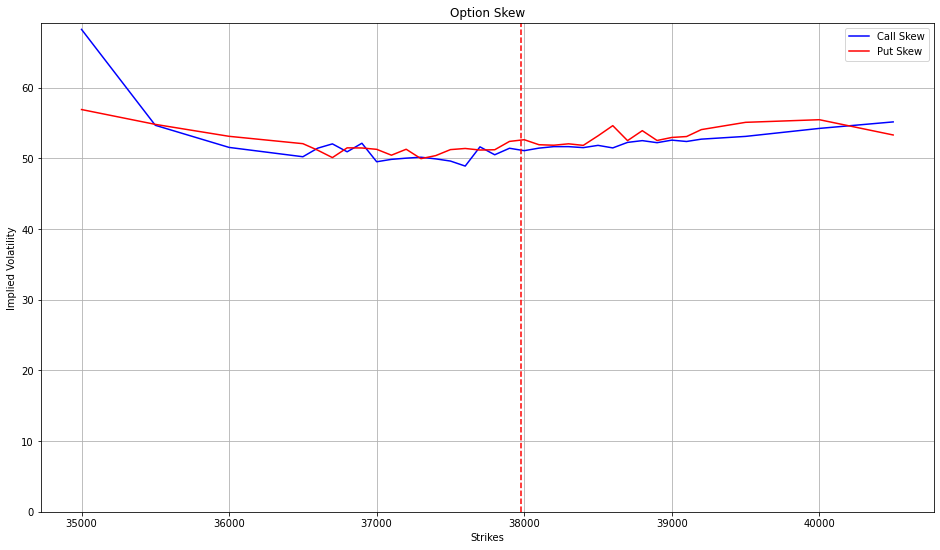

In [64]:
plot_graph_expiry(expiry_df, 0)

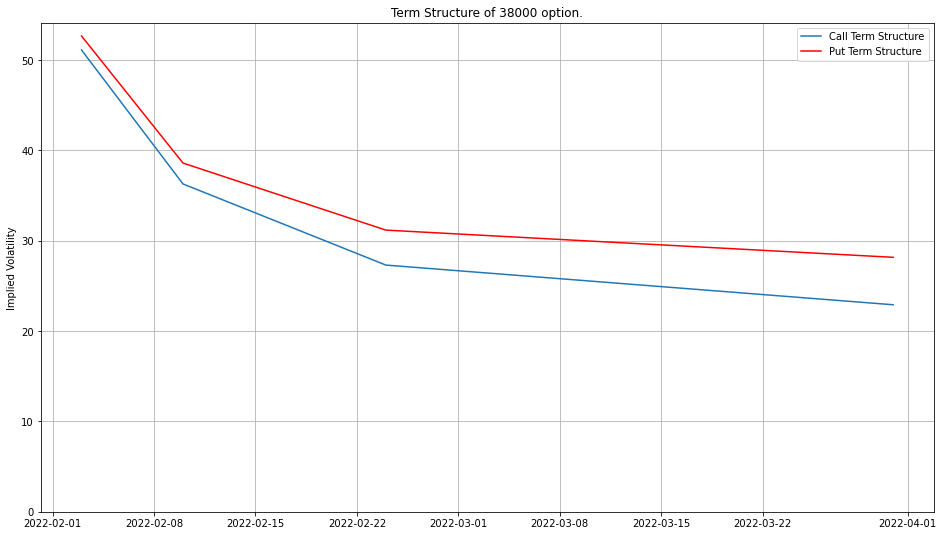

In [66]:
plot_graph_strike(strike_df, 38000)